In [64]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
from plot_field import generate_afl_oval, plot_events
import seaborn as sns
import matplotlib.pyplot as plt

venueWidth = (123/2)
venueLength = (167/2)
venueDims = (-venueLength, venueLength, -venueWidth, venueWidth)
defaultVenue = 'Adelaide Oval'

# Next position
chains_processed =  pd.read_pickle("../data/chains_processed.pkl")
# 1. Record scores against kicks

chains_processed['points'] = np.select([chains_processed.description == "Goal", chains_processed.description == "Behind"], [6, 1], default=np.NaN)
chains_processed['points'] = chains_processed['points'].shift(-1)

# 2. Reset goal positions
finCondList = [chains_processed.description == "Goal",
            chains_processed.behindInfo =='missLeft',
            chains_processed.behindInfo =='leftPost',
            chains_processed.behindInfo =='missRight',
            chains_processed.behindInfo =='touched',
            chains_processed.behindInfo =='rightPost']
## Y next pos
finychoiceList = [0,
              6.4,
              3.2,
              -6.4,
              0,
              -3.2]
## X next pos
finxchoiceList = [167/2] * 6

## Record condition for debugging
nextCondChoice = ['G',
                 'ML',
                 'LP',
                 'MR',
                 'Touched',
                 'RP']

chains_processed = chains_processed.assign(x = np.select(finCondList, finxchoiceList, default=chains_processed.x),
                                           y = np.select(finCondList, finychoiceList, default=chains_processed.y),
                                           Cond = np.select(finCondList, nextCondChoice, default='Def'))

chains_processed['shotAtGoal'] = chains_processed.shotAtGoal.replace(np.NaN,False)

chains_processed['x'] = np.where(chains_processed.description == "Goal", (167/2), chains_processed.x)
chains_processed['y'] = np.where(chains_processed.description == "Goal", 0, chains_processed.y)
# 2. shift next pos
chains_processed['x_next'] = chains_processed.groupby(['season', 'roundNumber', 'homeTeam', 'period'], as_index=False)['x'].shift(-1)
chains_processed['y_next'] = chains_processed.groupby(['season', 'roundNumber', 'homeTeam', 'period'], as_index=False)['y'].shift(-1)

finCondList = ((chains_processed.description == 'Spoil') & (~chains_processed.playingFor.shift(-1).isnull()) & \
    (~chains_processed.playingFor.shift(1).eq(chains_processed.playingFor.shift(-1)))) | \
    (chains_processed.possChng & chains_processed.finalPos & \
              (chains_processed.finalState.isin(["turnover", 'rushed'])) & \
              (chains_processed.description != 'Out On Full After Kick') & \
              (chains_processed.description.shift(-1) != 'Spoil'))

fCondTemp = [(chains_processed.description == 'Spoil') &  (~chains_processed.playingFor.shift(-1).isnull()) & \
    (~chains_processed.playingFor.shift(1).eq(chains_processed.playingFor.shift(-1))), 
    (chains_processed.possChng & chains_processed.finalPos & \
              (chains_processed.finalState.isin(["turnover", 'rushed'])) & \
              (~chains_processed.description.isin(['Out On Full', 'Out On Full After Kick'])) & \
              (chains_processed.description.shift(-1) != 'Spoil'))]

chains_processed = chains_processed.assign(x_next = np.where(finCondList, -chains_processed.x_next, chains_processed.x_next),
                                           y_next = np.where(finCondList, -chains_processed.y_next, chains_processed.y_next),
                                           Cond2 = np.select(fCondTemp, ['TO1', 'TO2'], 'Def'))

# 3. Set kickin as middle of the goal square
chains_processed['x'] = np.where(chains_processed.description.str.contains('Kickin') & chains_processed.description.shift(1).isin(['Goal', 'Behind']), -venueLength + 5, chains_processed.x)
chains_processed['y'] = np.where(chains_processed.description.str.contains('Kickin') & chains_processed.description.shift(1).isin(['Goal', 'Behind']), 0, chains_processed.y)

# 4. Remove game events
game_events = ['Out On Full After Kick', 'Out of Bounds', 'Ball Up Call', 'Goal', 'Behind','Kick Inside 50 Result', 'OOF Kick In']

chains_processed = chains_processed[~chains_processed.description.isin(game_events)]


# 5. Calculate distance for QA
def calc_dist(x0, y0, x1, y1):
    x0 = np.array(x0, dtype=float)
    y0 = np.array(y0, dtype=float)
    x1 = np.array(x1, dtype=float)
    y1 = np.array(y1, dtype=float)
    return np.sqrt((x1-x0)**2 + (y1 - y0)**2)

chains_processed = chains_processed.assign(possDist = calc_dist(chains_processed.x, chains_processed.y, chains_processed.x_next, chains_processed.y_next))


In [88]:
bin_period = 25

venueWidth = (123/2)
venueLength = (167/2)
venueDims = (-venueLength, venueLength, -venueWidth, venueWidth)


def bin_values(col, dir='x'):
    if dir == 'x':
        s = -venueLength; e = venueLength
    else:
        s = -venueWidth; e = venueWidth
    return pd.cut(col.values, pd.interval_range(start=s, end=e, periods=bin_period, closed='right'), include_lowest=True, precision=2)

x_bins = pd.interval_range(start=-venueLength, end=venueLength, periods=bin_period, closed='right')
y_bins = pd.interval_range(start=-venueWidth, end=venueWidth, periods=bin_period, closed='right')

chains_processed = chains_processed.assign(xInitialPoss_bin=bin_values(chains_processed.x, 'x'),
                                                yInitialPoss_bin=bin_values(chains_processed.y, 'y'),
                                                xFinalPoss_bin=bin_values(chains_processed.x_next, 'x'),
                                                yFinalPoss_bin=bin_values(chains_processed.y_next, 'y'))

disposal_actions = ['Kick', 'Handball', 'Spoil','Ground Kick', 'Kickin short', 'Kickin long', 'Kickin play on']

movement_df = chains_processed[chains_processed.description.isin(disposal_actions)]

See here - https://soccermatics.readthedocs.io/en/latest/gallery/lesson4/plot_ExpectedThreat.html

## Step 1

Select only positive disposal type actions

TO DO: Include turnovers, out of bounds


In [84]:
all_count = movement_df[['xInitialPoss_bin','yInitialPoss_bin']].value_counts()
move_count = movement_df[~movement_df.shotAtGoal][['xInitialPoss_bin','yInitialPoss_bin']].value_counts()
shot_count = movement_df[movement_df.shotAtGoal][['xInitialPoss_bin','yInitialPoss_bin']].value_counts()
score_count = movement_df.groupby(['xInitialPoss_bin','yInitialPoss_bin']).points.agg('sum')

move_probability = move_count.div(all_count, fill_value=0)
shot_probability = shot_count.div(all_count, fill_value=0)
score_probability = score_count.div(shot_count, fill_value=0).div(all_count.apply(lambda x: 1), fill_value=1).replace(np.NaN, 0)
score_probability = score_probability.rename('xG')

C:\Users\Dave Scroggs\AppData\Local\Temp\ipykernel_1144\524239923.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plot_df = movement_df[~(chains_processed.description == "Kickin play on")][['xInitialPoss_bin','yInitialPoss_bin']].value_counts().reset_index()


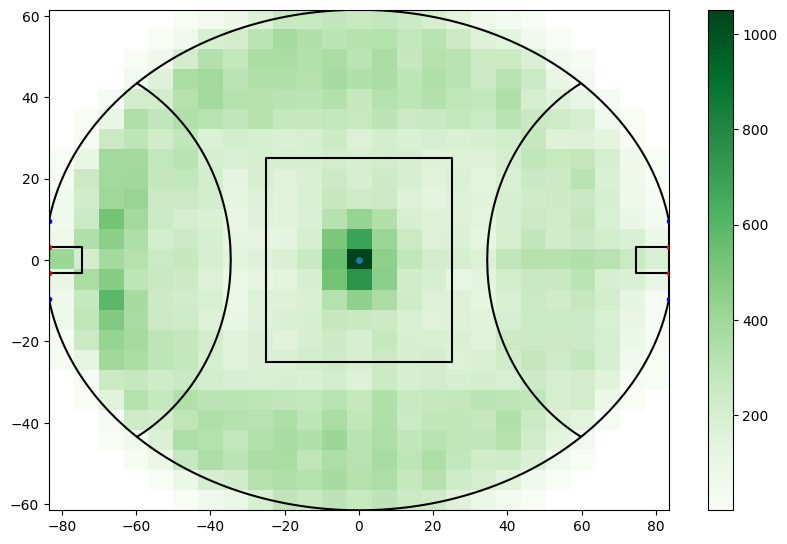

In [89]:
plot_df = movement_df[~(chains_processed.description == "Kickin play on")][['xInitialPoss_bin','yInitialPoss_bin']].value_counts().reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3))
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3))
plot_df = plot_df.pivot(index='y', columns='x', values='count')

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Greens')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

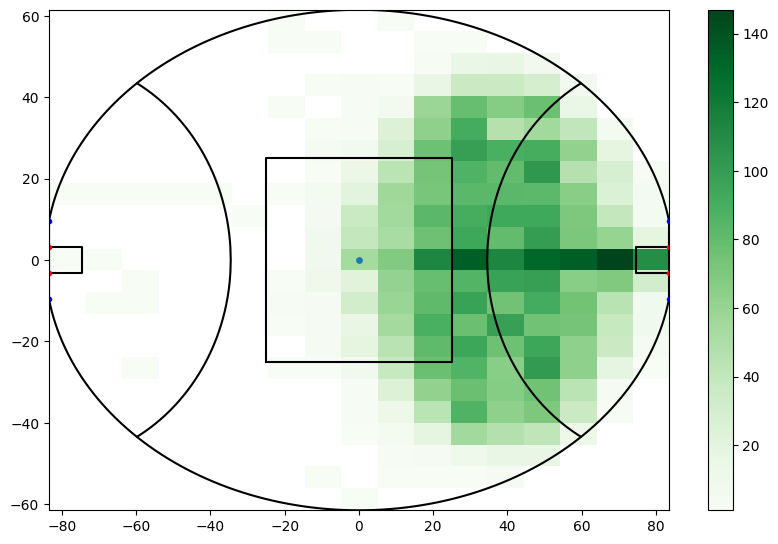

In [90]:
plot_df = movement_df[movement_df.shotAtGoal][['xInitialPoss_bin','yInitialPoss_bin']].value_counts().reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3))
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3))
plot_df = plot_df.sort_values(by='y')
plot_df = plot_df.pivot(index='y', columns='x', values='count')
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Greens')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

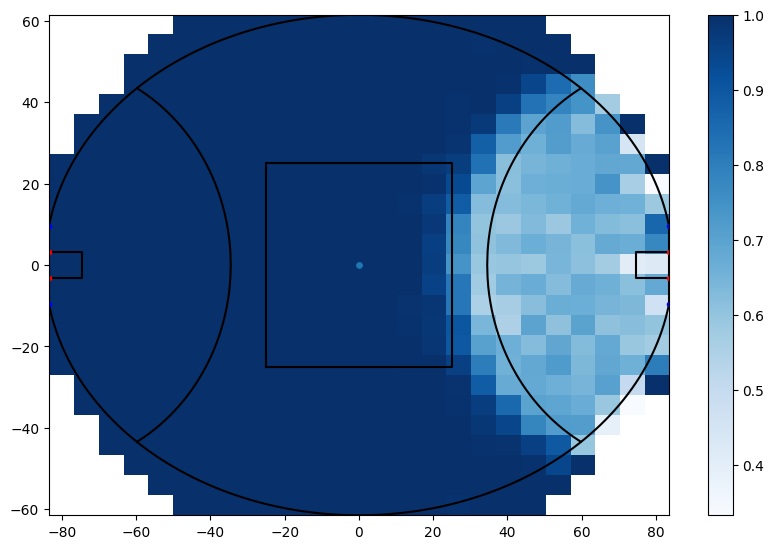

In [91]:
plot_df = move_probability.reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df = plot_df.sort_values(by='y')
plot_df = plot_df.pivot(index='y', columns='x', values='count')
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Blues')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

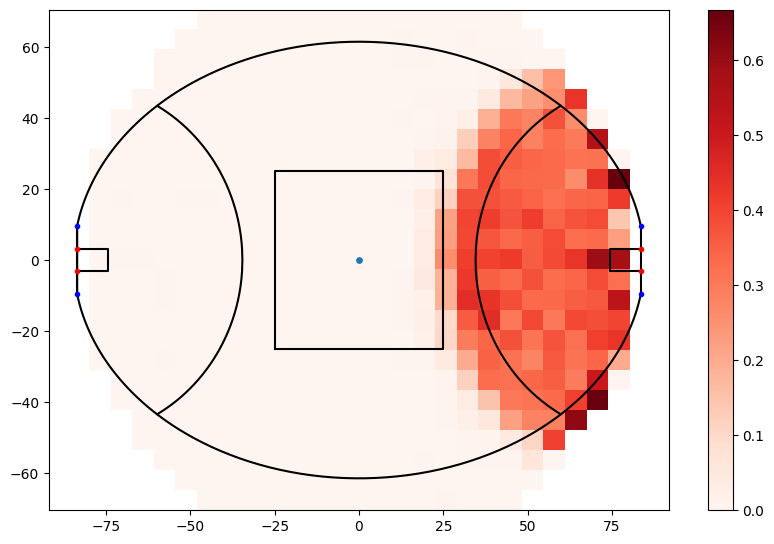

In [92]:
plot_df = shot_probability.reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df = plot_df.sort_values(by='y')
plot_df = plot_df.pivot(index='y', columns='x', values='count')
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=(-80,80, -70.5, 70.5), 
          cmap='Reds')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

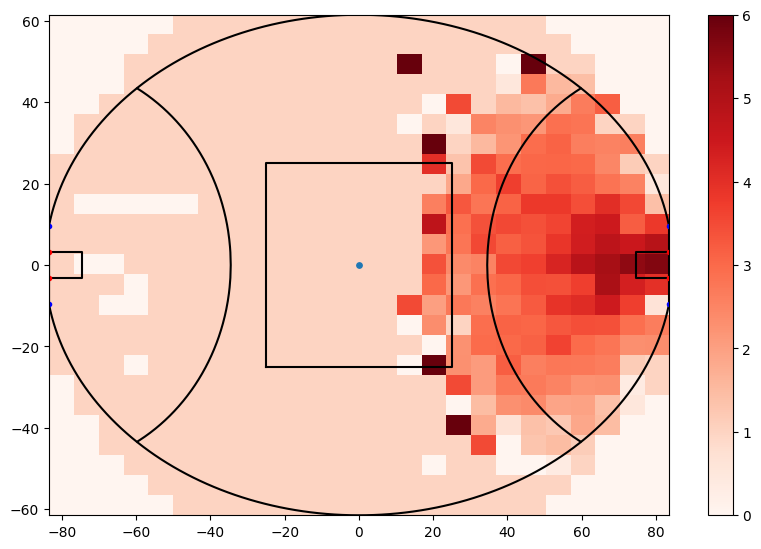

In [93]:
plot_df = score_probability.reset_index()
plot_df['x'] = plot_df.xInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df['y'] = plot_df.yInitialPoss_bin.apply(lambda s: np.round(s.values.left,3)).astype('float')
plot_df = plot_df.sort_values(by='y')
plot_df = plot_df.pivot(index='y', columns='x', values='xG')
plot_df = plot_df.reindex(columns=sorted(plot_df.columns))

fig=plt.figure(figsize=(10, 6.5))
ax=fig.add_subplot()
pcm = ax.imshow(plot_df, zorder=0, aspect="auto", extent=venueDims, 
          cmap='Reds')
plt.colorbar(pcm)
generate_afl_oval(defaultVenue)

## Transition matricies

In [ ]:
transitions = possession_summary.groupby(['xInitialPoss_bin','yInitialPoss_bin','xFinalPoss_bin', 'yFinalPoss_bin']).aggregate(shots = ('shotAtGoal', sum),
                                                                           goals = ('goals', sum),
                                                                           behinds = ('behind', sum),
                                                                           total_events = ('possessionNum', 'size'))

transitions.loc[x_bins[10],y_bins[10], :, :].sort_values(by='total_events',ascending=False).head(30)